## IMDb
<div class="alert alert-block alert-info">NB: This notebook is based on [Fastai Notebook Lesson 10](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb) 
</div>

In [1]:
import time
t0 = time.clock()
time.ctime(time.time())

'Sun May 13 08:24:54 2018'

`fastai.text` replaces the torchtext library, and supersedes the fastai.nlp library, but retains many of the key functions.

In [2]:
from fastai.text import *
import html

The `fastai.text` module introduces several custom tokens.

We need to download the [IMDB large movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/)
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) 
and untar it into the PATH location. 
```
curl -OL http://files.fast.ai/data/aclImdb.tgz
tar -xzf aclImdb.tgz
```

In [3]:
PATH=Path('data/aclImdb/')

## Standardize format

### Get the Dataset

In [4]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes: positive, negative and unsupervised (sentiment is unknown). 
- 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
- 25k validation reviews(12.5k pos, 12.5k neg & no unsup)
See README file in the imdb corpus for further information about the dataset.

In [5]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [6]:
len(trn_texts),len(val_texts)

(75000, 25000)

### Shuffle the training and validation data

Use `np.random.permutation()` to create a set of randomly permuted indexes in the corresponding range, 
which are then used to *shuffle* the text reviews.

In [7]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [8]:
val_idx, trn_idx  # randomly permutated

(array([23481, 13606, 13639, ..., 22410,  9907, 24798]),
 array([26837,  2592, 18359, ..., 54886,   860, 15795]))

Shuffle the training and validation sets (texts and labels) with the right indexes

In [9]:
trn_texts = trn_texts[trn_idx]
trn_labels = trn_labels[trn_idx]

val_texts = val_texts[val_idx]
val_labels = val_labels[val_idx]

### Format using new "standard"
Fastai adopts a recent (LeCun paper) "standard" format for NLP datasets: label followed by text columns. 
For IMDB, there is only one text column.

In [10]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

Notice that for clasification we remove label $2$ 'unsup' as they are not useful for training.
Hovewer, for the LM they will be useful.

In [11]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

### Create data for Language Model (LM)
The LM's learns the **structure** of English, 
by trying to predict the next word given a set of previous words(ngrams).
Since the LM does not classify reviews, the labels are ignored.
The LM can benefit from all the textual data, so we include the unsup/unclassified movie reviews.

First concat all the train (pos/neg/unsup = **75k**) and test (pos/neg=**25k**) reviews into a big chunk of **100k** reviews. 
```
np.concatenate([trn_texts,val_texts])
```
Then use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets.

In [12]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

len(trn_texts), len(val_texts)

(90000, 10000)

In [13]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Pre-Processing - Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Tokenize the data. 

fastai now adds `Tokenizer()`, a faster, parallel/multicore version of the [spaCy tokenizer](http://spacy.io), 
which uses all the CPU cores. 

Before passing it to spaCy, there are a few things that need to be fixed....
Many kinds of different things on different text datasets, which we would like to "clean-up"
`fixup(x)` includes some fixes that JH found useful.

In [14]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

Tokenization is splitting the text into separate tokens, each token assigned a unique index, 
which our models can use.  
Tokens are "kind-of" words, but not exactly.

In [15]:
#These strings do not appear often.
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

The above tokens are very useful. For example, now we have a new one, forget about the old, etc.

Tokenizing is slow, so fastai will use multi-processing using `proc_all_mp`.
`partition_by_cores(texts)` divides the texts into pieces for the number of cores in the computer.
Few things in python leverages multi-threading....

In [16]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [17]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

We use pandas, which can be very inneficient... like python, in storage, they use a lot of RAM.
Thus, few people in NLP work on large corpuses, as tools make it difficult.
JH has used the code below with corpuses of over 1B words.
We use an appropriate chunksize as the tokenization process is memory intensive.
With `chunksize` pandas does not return a full dataset, but returns an iterator that we can use.
Above, in `get_all` we use `enumerate(df)` which uses the iterator to go thru the chunks of data of size `chunksize`.

In [18]:
chunksize=24000

In [19]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

Now tokenize, this will take time, so `get_all()` prints the current i

In [20]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [21]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [22]:
' '.join(tok_trn[0])

'\n xbos xfld 1 i have just seen this movie , on tv . saturday , drinking tea , and using the remote control hoping for a miracle in channel 12 of montevideo , uruguay . and it appears ! ! ... this is a very nice movie , you can laugh , think , cry and find references to events , characters , behaviors of many people at their time . and seeing on 2005 , after how comics and cartoons have evolved it is a pleasure . it was a pity that i could not enjoy billy cristal \'s voice cause it was in spanish . it contains many jokes , references to particular historical situations . it portraits quite well the life of athletes and how maybe they give all their life such in gymnastics . i really enjoy this " before born " joke about her .'

In [23]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [24]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

What are the most frequently used tokens in the vocalubalary?

In [25]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1208506),
 ('.', 993054),
 (',', 986089),
 ('and', 588243),
 ('a', 583522),
 ('of', 524941),
 ('to', 485834),
 ('is', 394273),
 ('it', 341863),
 ('in', 337992),
 ('i', 308495),
 ('this', 270551),
 ('that', 261509),
 ('"', 237372),
 ("'s", 221370),
 ('-', 188030),
 ('was', 180707),
 ('\n\n', 179108),
 ('as', 166065),
 ('with', 159368),
 ('for', 158837),
 ('movie', 157400),
 ('but', 150598),
 ('film', 144190),
 ('you', 124110)]

The *vocab* is the **unique set of all tokens** in our dataset. 
The vocab provides a way to replace each word in our datasets with a unique integer (index).
In a large corpus of data one might find rare words which are only used a few times. 
We discard such rare words as it would be hard to learn meaningful patterns out of them.

We limit our vocabulary to 60K words, and we set a minimum frequency of word occurence to 2 times. 
NLP practicioners observed that a maximum vocab of 60K usually yields good results for classification tasks. 

In [26]:
max_vocab = 60000
min_freq = 2

Below we get the `max_vocab` (60000) most frequent ones, only picking those that appear more than `min_freq`.
Then add 2 more tokens, a token for `_unk_` and a token for `_pad_`.

In [27]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(1, '_pad_')
itos.insert(0, '_unk_')

We create a *reverse mapping* called `stoi` to lookup the index of a given token. 
`stoi` has the same number of elements as `itos`. 
We use a high performance container called 
[collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) 
to store our stoi mapping.

If we find something not in the dictionary `enumerate(itos)`, we replace it with `\_unk_` (token 0)

In [28]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

Now we call `stoi` for every word on every sentence in the training and validation sets, to get the numericalaized versions.

In [29]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [30]:
' '.join(str(o) for o in trn_lm[0])

'40 41 42 39 12 36 56 130 13 23 4 28 264 3 2386 4 2522 3964 4 5 800 1 2700 1141 1377 22 6 5097 11 1234 1771 7 32109 4 25539 3 5 10 748 49 49 92 13 9 6 69 358 23 4 26 77 447 4 122 4 1531 5 185 1988 8 713 4 120 4 12747 7 127 99 44 78 74 3 5 335 28 3203 4 118 108 3815 5 2193 36 8627 10 9 6 1757 3 10 18 6 2320 14 12 95 32 389 1407 41984 16 581 1165 10 18 11 1917 3 10 1424 127 653 4 1988 8 898 1296 1128 3 10 12748 204 89 1 135 7 14066 5 108 299 45 220 43 78 135 159 11 21328 3 12 83 389 13 15 179 1370 15 997 58 55 3'

Lets save the vocabularies for training and validation, to be able to later interpret them.

In [31]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [32]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [33]:
vs=len(itos)
vs,len(trn_lm)

(60002, 90000)

## wikitext103 conversion

Lets build an English language model for the IMDB corpus, using *transfer learning*, a recent idea for NLP.
We use a `pre-trained` LM that has been trained on a large generic corpus (_like wikipedia articles_),
transfer it's knowledge to a target LM, and then the weights can be fine-tuned.

Our source LM is the wikitext103 LM 
[Dataset by Stephen Merity @ Salesforce Research.](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained (by JH?) and the weights can be downloaded 
[here](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [34]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. 
We need to match these values  with the target `IMDB LM` so that the weights can be loaded up.

In [35]:
em_sz,nh,nl = 400,1150,3

In [36]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [37]:
%pwd

'/home/german/DeepLearning'

In [38]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate `row_m`, the mean of the layer0 encoder weights. 
This mean (the average embedding weight) is used to assign weights to unknown tokens (as default initialization) when we transfer to target IMDB LM.

In [39]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

**NB:** The LM for wikitext103 was done with a different vocabulary, indexes. 
Fortunately, we do have access to that vocabulary in `itos_wt103.pkl`
So, before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.
`itos2` and `stoi2` are for wikitext103.
Here we use $-1$ to indicate unknown word.

In [40]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

To convert, first we create a np zeros array.
Then we go thru all our vocabulary (`itos`), and look up the word in the 2nd dataset 
```
r = stoi2[w]
```
Then if the word was not found (not $-1$), then we use the corresponding `enc_wgts`, else the special `row_m`


In [41]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [42]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

We will use a Language Model, which gives much better results than embeddings. For years most NLP researchers are attached to embeddings, which is a fixed model. We knew on CV that this does not work (it was hyper-columns). Fine-tuning the entire model works much better.

The model will have a backbone (the IMDB LM pre-trained with wikitext) and a custom head (a linear classifier). 

### Backbone
In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

In [43]:
wd=1e-7
bptt=70
bs=42   #52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

NB: the total length of the training LM is `t= len(np.concatenate(trn_lm))`, (here $\approx 25M$). 
If we use a batch size of, e.g., bs=64, then we will be creating 64 batches of  size $t \div bs$, (here $\approx 390K$)

In [44]:
t = len(np.concatenate(trn_lm))
t, t//64

(25012685, 390823)

The LM is stateful. 
The **goal** of the LM is to learn to **predict a word/token** given a preceeding set of words(tokens). 

We take all the movie reviews (90k training set and 10k validation set) and concatenate them to form long strings of tokens. 
We use text.py `LanguageModelLoader` class, that
takes a concatenated string of tokens and returns a data loader for `bptt`-sized mini batches. 
So we have bs=64 columns by `len(np.concatenate(trn_lm)) // bs` rows.
And we grab, at each time, `bptt` rows.

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. 
batch-size is constant, but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. 
(original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

**NB:** The `LanguageModelLoader` can not shuffle the data, as we would normally do, 
because a language model needs to learn sequentially, the context of the sentence matters a lot. 
Since we can't do that, lets try to change the size...
But if we always grab `bptt` sized, then we always will get the same data in all epochs...
Hence, fastai uses Merity's trick, to adjust the *length*. 
In 95% of the cases it uses `bptt` as defined, but in 5% it divides `bptt` by 2.
Then it makes the sequence length a normally distributed random number, with a mean of `bptt`, and a std of 5.
So the sequence length is `bptt`-ish, every time we get a size of slightly different batches.

```
bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
seq_len = max(5, int(np.random.normal(bptt, 5)))
```

`bptt` (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. 
This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In `text.py` we have a special modeldata object class for LMs called `LanguageModelData` 
to which we can pass the training and validation loaders and get in return the model itself.

See `LanguageModelData()` in text.py, to review how this class is defined. [1:10].
fastai uses `to_gpu()` as a more flexible approach to choose where to put the model.

In [45]:
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

**NB:** Droputs are important!. JH setup the dropouts for the model, with values chosen after experimentation.  
We may need to update them for custom LMs.
For example, we can change the weighting factor `dwfactor` (=0.7 here) based on the amount of data available. 
JH claims that all what is needed is to change `dwfactor`.
The more data that is available, the less dropout that is needed, hence a lower `dwfactor`.
For small datasets, we can reduce overfitting by choosing a higher dropout factor. 
**No other dropout value requires tuning**

In [46]:
dwfactor = 0.7
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*dwfactor

Review of dropout types in Stephen Merity's [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182)

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [47]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [48]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the *wikitext103* learn better weights.

In [49]:
lr=1e-3
lrs = lr

**NB:** Use of `use_clr(a,b)`  This is based on Leslie Smith paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).
Here the `lr` value represents the maximum value that the learning rate may take.
`a`, is the scale between the minimum and your maximum, i.e., by how much the learning rate is divided to get the minimum value. 
`b` is the split of the cycle between increasing and decreasing: 
For example, with a=20, b=5:  use_clr(20,5), given lr=0.01, begins at $0.01 / 20 = 0.0005$,
with 1/5 of growth and 4/5 of descent.  Leslie recommends using this for a single cycle only.

In [50]:
%time learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.692012   4.448833   0.257947  

CPU times: user 20min 24s, sys: 8min 40s, total: 29min 5s
Wall time: 28min 52s


[array([4.44883]), 0.25794688757426354]

**NB** we track `accuracy`, i.e., the rate it predicts the target word correctly. 
`accuracy` is a good metric to check, but it is **not** part of our loss function as it can get "bumpy". 
We only minimize Cross-Entropy Loss in the LM.
There are lots of problems with comparing based on CEL... basically because if penalizes models that are not so sure, ie lack confidence...  Accuracy tells us how good we are doing in our predictions, and is more stable.
That is why we track both.
**TODO: How does this relate to MIT work on confidence?**

In [51]:
learner.save('lm_last_ft')

In [52]:
learner.load('lm_last_ft')

In [53]:
learner.unfreeze()

In [54]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.81424    4.635004   0.244239  



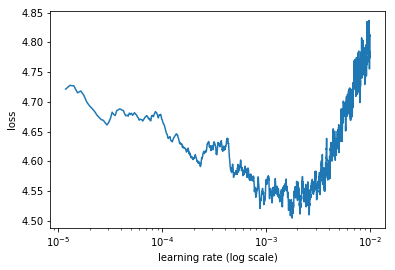

In [55]:
learner.sched.plot()

In [56]:
%time learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.384418   4.171102   0.285469  
    1      4.264403   4.103605   0.291715                     
    2      4.191735   4.057564   0.296622                     
    3      4.17492    4.030737   0.299519                     
    4      4.159534   4.011856   0.301418                     
    5      4.087927   3.998196   0.303012                     
    6      4.066455   3.986265   0.30448                      
    7      4.097224   3.975422   0.305758                     
    8      4.018887   3.969066   0.306902                     
    9      4.020799   3.96008    0.307912                     
    10     3.994351   3.95426    0.308849                     
    11     3.973335   3.947343   0.309582                     
    12     3.954658   3.941512   0.310499                     
    13     3.983358   3.934531   0.311326                     
    14     3.959226   3.93117    0.311791                     

CPU times:

[array([3.93117]), 0.31179063867782536]

After training for a while (15 cycles) we get a CEL of $\approx 3.9.$.
The **Perplexity** metric of the LM is the exponent of the CEL.  Lower perplexity is better.
In 2017, perplexity state-of-the-art was above 100, now we reach $\approx 50$.
NLP is rapidly advancing...

In [57]:
math.exp(3.9)   

51.00583306460888

We save the trained model weights `lm1`.
Separately, we save the encoder `lm1_enc` part of the LM model.
That is, we save the `RNN_encoder()` part, but we do not save the `LinearDecoder()`. We don't care about the LM generator any more.
The `lm1_enc` will be the backbone in the classification task model.

In [58]:
learner.save('lm1')

learner.save_encoder('lm1_enc')

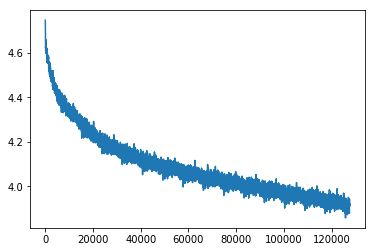

In [59]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [60]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [61]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [62]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [63]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

**NB:** We don't create a new `itos` vocabulary, we want to use the **same** as we used in the language model.

In [64]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [65]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [66]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now lets create the final model, a classifier as a custom linear head over the trained IMDB backbone. 
The steps to create the classifier model are similar to the ones for the LM.

In [67]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [68]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [69]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 20   # pick as big as possible given the memory available...  with 40 we use > 8GB

In [70]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we read a movie review and learn to predict the sentiment as pos/neg. 
Now we do want to shuffle the documents, as each one is independent of the others.
We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. 
To create batches of similar sized movie reviews, we use a **sortish sampler method** invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury).
In Pytorch this is very elegant to implement.
The `sortishSampler` cuts down the overall number of padding tokens the classifier ends up seeing.
We use it on the training set.  For the validation set just sort.

In [71]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

Below we create the datasets for the training and validation, then assign the sampler (sort and sortish), 
and invoke the DataLoader to get the data-loaders.<br>
Notice that the `DataLoader` is provided by fastai, similar to torchtext but faster as it is multithreaded.

In [72]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [73]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

Now we can call `get_rnn_classifier()` to create the classifier, using similar parameters as before.
But now we can do more things, for example, add more layers, with dropouts, etc. For example:
```
layers=[em_sz*3, 50, c]
```

In [74]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [75]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

Lets use the RNN_Learner just as before.

In [76]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

Lets use `discriminative learning rates`.

In [77]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [78]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

Experiment with Weight Decay (`wd`)?

In [79]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')  # lm2_enc')

In [ ]:
We start out by only training the last layer.

In [80]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 1264/1667 [07:39<02:26,  2.75it/s, loss=1.28] 

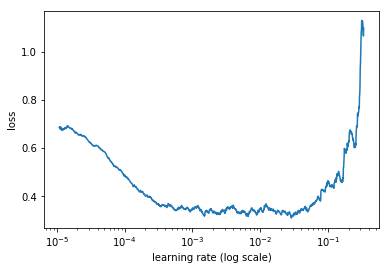

In [81]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [82]:
%time learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 1/1667 [00:00<07:42,  3.60it/s, loss=0.588]

Exception in thread Thread-33:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.293649   0.197152   0.926164  

CPU times: user 10min 3s, sys: 1min 34s, total: 11min 37s
Wall time: 11min 33s


[array([0.19715]), 0.926163704674685]

In [83]:
learn.save('clas_0')

In [84]:
learn.load('clas_0')

Now we unfreeze one more layer and improve our accuracy.

In [85]:
learn.freeze_to(-2)

In [86]:
%time learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.246198   0.182977   0.933871  

CPU times: user 10min 33s, sys: 1min 41s, total: 12min 15s
Wall time: 12min 11s


[array([0.18298]), 0.9338706410266475]

In [87]:
learn.save('clas_1')

In [88]:
learn.load('clas_1')

And now, lets fine tune the whole thing...

In [89]:
learn.unfreeze()

Notice that after 3 epochs we are getting 94.8% accuracy, beating the state-of-the-art, which was $\approx 94%$.
[Learned in translation: Contextualized Word Vectors](https://arxiv.org/abs/1708.00107) used a translation model, but did not fine tune the whole thing. Just took the activations of the translation model.
On IMDb they got $\approx 91%$, which we reached in 1 epoch.

In [90]:
%time learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

  1%|          | 14/1667 [00:07<13:54,  1.98it/s, loss=0.287]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCStorage.cu:58

An idea to improve is to use bi-direction: <br>
Go to the start of the document, reverse the order of all of the documents, and do everything again. 
When we get to use the `fwd_wt103.h5` model, we replace it with `bwd_wt103.pt`, the backward model.  
That is a backward language model that learns English backwards. 
Then we have 2 classifiers... We take the 2 predictions, average them and that is a bi-directional language model. This will exceed $95.4%$ accuracy, which is a $20%$ change in the state-of-the-art.
Hence, transfer-learning is powerful, but every-field thinks they are special and they don't do it...

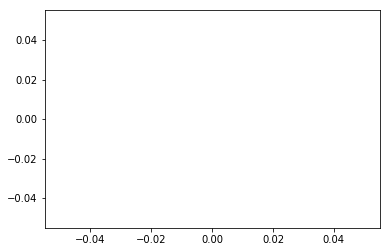

In [91]:
learn.sched.plot_loss()

JH worked on a paper w/Sebastian Ruder **[Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/pdf/1801.06146),** which included the ablation studies, etc. 
Then formalized **`discriminative learning rates`** and **`Gradual unfreezing`.**  Also added some math. 
They also added the idea of `concat pooling`.

They also used the newer idea of `cyclical Learning Rates` that was introduced by Leslie Smith's **[A Disciplined Approach to Neural Network Parameters: Part I - Learning Rate, Batch Size, Momentum, and Weight Decay](https://arxiv.org/abs/1803.09820),**.  This is a great paper to read and summarize...

Used all the datasets that LeCun used (IMDb, TREC-6, AG, DBpedia, Yelp-bi, Yelp-full) on a recent paper and obtained better results, even against customized algorithms that were state of the art.

Sebastian did the **ablation** studies which explain what are the contributions of the different ideas. (See ppt, will be in future paper?)
This is done by removing each of the components and evaluating their contribution.

The most interesting was, what is the validation error rate with fewer examples. 
With only 100 example it reached a much lower error rate than others reached with many more trainingexamples.
So, this is most beneficial when there is little data.

Valuable to use:
```
pip install -e .
```
creates a symlink into your ~/site-packages/  
makes it simpler to keep track..
But it may confuse conda...

### Google tools for NLP

[Google Fire library](https://github.com/google/python-fire) is great for ablation studies.
JH put all the scripts under `dl2/imdb_scripts`. **TODO: review these scripts.**

[SentencePiece](https://github.com/google/sentencepiece) is useful to tokenize in sub-word units, etc.
JH got results nearly as good as word tokenization... suspect it could be better...
But in any case, it is good because end up with vocabulary of sub-units which is very good...
It is a bit difficult to install, bad error messages, etc.

SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. Subword segmentation with unigram language model supports probabilistic subword sampling for subword regularization [Kudo.], a simple technique to improve the robustness of NMT model. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.

In [92]:
learn.save('clas_2')

**BPT3C**. 
Language models are trained with backpropagation through time (BPTT) to enable gradient propagation for large input sequences.  
The problem is that for classification, a document can be very long, eg 2000 words. The whole gradients would not fit on the GPU.
In order to make fine-tuning a classifier for large documents feasible, we propose BPTT for Text Classification (BPT3C): 
We divide the document into fixed-length batches of size $b$. 
At the beginning of each batch, the model is initialized with the final state of the previous batch; 
we keep track of the hidden states for mean and max-pooling; 
gradients are back-propagated to the batches whose hidden states contributed to the classifier prediction 
at the end of the document. 
In practice, we use variable length backpropagation sequences (per Merity et al.).

## Fin

In [93]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)

('Sun May 13 18:15:15 2018', 35395.25425)

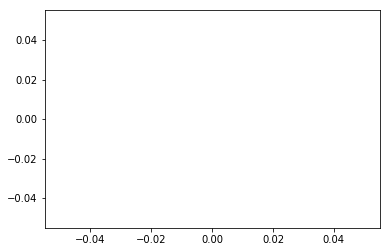

In [94]:
learn.sched.plot_loss()